In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [44]:
df = pd.read_csv('../data/processed_weather_data.csv')
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Hour,Day,Month,Year,Weekday
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,22,31,3,2006,4
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,23,31,3,2006,4
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,0,1,4,2006,5
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,1,1,4,2006,5
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,2,1,4,2006,5


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               96453 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Pressure (millibars)      95165 non-null  float64
 10  Daily Summary             96453 non-null  object 
 11  Hour                      96453 non-null  int64  
 12  Day                       96453 non-null  int64  
 13  Month                     96453 non-null  int64  
 14  Year  

# Preprocessing

In [46]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
df = df.set_index('Formatted Date')
df = df.sort_index()
df['Pressure (millibars)'] = df['Pressure (millibars)'].ffill().bfill()

# Feature Engineering

In [47]:
# Create cyclical features
df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24.0)
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)

In [48]:
# Group rare 'Summary' classes
summary_counts = df['Summary'].value_counts()
top_5_classes = summary_counts.nlargest(5).index.tolist()

In [49]:
# Create a new column 'Summary_Grouped'
df['Summary_Grouped'] = df['Summary'].apply(lambda x: x if x in top_5_classes else 'Other')

print("New value counts for 'Summary_Grouped':")
print(df['Summary_Grouped'].value_counts())

New value counts for 'Summary_Grouped':
Summary_Grouped
Partly Cloudy    31733
Mostly Cloudy    28094
Overcast         16597
Clear            10890
Foggy             7148
Other             1991
Name: count, dtype: int64


# Define Features and Target

In [50]:
target = 'Summary_Grouped'

numerical_features = [
    'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 
    'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 
    'Pressure (millibars)', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]
categorical_features = ['Precip Type']
features = numerical_features + categorical_features

# Chronological Data Split (80% train, 20% test)

In [51]:
split_point = int(len(df) * 0.8)
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

print(f"\nTraining data points: {len(X_train)}")
print(f"Test data points: {len(X_test)}")


Training data points: 77162
Test data points: 19291


# Create Preprocessing Pipeline

In [52]:
# Numerical transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [53]:
# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [54]:
# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create and Train the Model (Logistic Regression)

In [55]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))
])

In [56]:
# Train the model
model_pipeline.fit(X_train, y_train)

print("\nModel (Logistic Regression) trained successfully.")

/Users/nghiemgiabao/Desktop/projects/Python/weather_forcast_project/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/nghiemgiabao/Desktop/projects/Python/weather_forcast_project/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/nghiemgiabao/Desktop/projects/Python/weather_forcast_project/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/nghiemgiabao/Desktop/projects/Python/weather_forcast_project/venv/lib/python3.9/site-packages/sklearn/linea


Model (Logistic Regression) trained successfully.


In [57]:
# Save model
joblib.dump(model_pipeline, '../models/summary_forecast_model.joblib')

['../models/summary_forecast_model.joblib']

# Evaluate the Model

In [58]:
# Make predictions
y_pred = model_pipeline.predict(X_test)

/Users/nghiemgiabao/Desktop/projects/Python/weather_forcast_project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nghiemgiabao/Desktop/projects/Python/weather_forcast_project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nghiemgiabao/Desktop/projects/Python/weather_forcast_project/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [59]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\n--- Model Evaluation ---")
print(f"Overall Accuracy: {accuracy:.4f}")


--- Model Evaluation ---
Overall Accuracy: 0.5085


In [60]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

        Clear       0.31      0.15      0.20      1698
        Foggy       0.79      1.00      0.88      1536
Mostly Cloudy       0.47      0.36      0.41      6235
        Other       0.83      0.67      0.74       360
     Overcast       0.42      0.41      0.42      3639
Partly Cloudy       0.51      0.69      0.59      5823

     accuracy                           0.51     19291
    macro avg       0.55      0.55      0.54     19291
 weighted avg       0.49      0.51      0.49     19291



# Visualize the Results (Confusion Matrix)

In [61]:
# Get class labels
labels = sorted(df['Summary_Grouped'].unique())

In [62]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)


Saved visualization to confusion_matrix_weather_summary.png


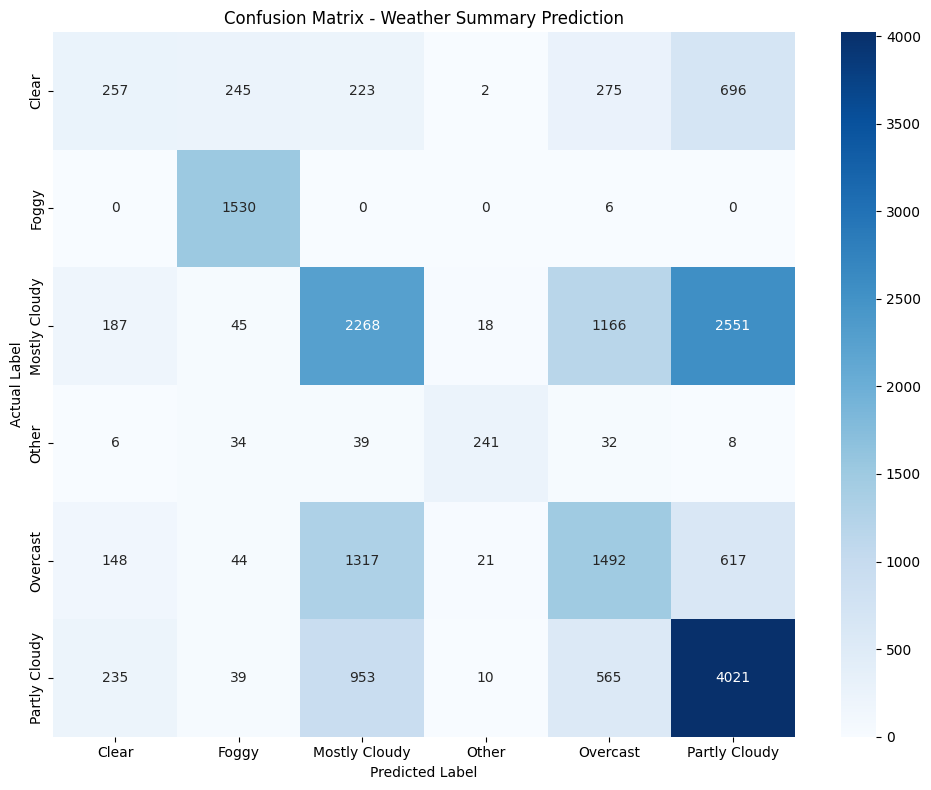

In [63]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Weather Summary Prediction')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Save the plot BEFORE showing or moving to next cell
plt.savefig('../charts/model/confusion_matrix_weather_summary.png', dpi=300, bbox_inches='tight')
print("\nSaved visualization to confusion_matrix_weather_summary.png")
plt.show()